# Flight Price Prediction using Machine Learning

## Project Overview
This project focuses on building a robust end-to-end machine learning pipeline to predict flight ticket prices. By analyzing real-world flight data, we aim to understand the key factors influencing airfares such as airline carrier, travel route, timing, and class and build predictive models to estimate future costs.

This notebook simulates a professional data science workflow, covering the following key stages:
1.  **Data Loading & Inspection**: Ingesting the 'Flight Price Dataset of Bangladesh' and understanding its schema.
2.  **Data Cleaning & Preprocessing**: Handling missing values, standardizing column names, and correcting data types.
3.  **Exploratory Data Analysis (EDA)**: Visualizing price distributions, seasonal trends, and correlations to derive actionable insights.
4.  **Feature Engineering**: Transforming raw dates and categorical attributes into machine-readable features.
5.  **Model Development**: Training and comparing regression models (Linear Regression, Random Forest, etc.).
6.  **Model Evaluation**: Assessing performance using industrial metrics like RMSE and R² Score.

Our goal is to deliver a model that provides accurate fare estimates, aiding in dynamic pricing strategies and travel cost planning.

In [29]:
# !pip install pandas numpy matplotlib seaborn scikit-learn

In [12]:
# 1. Import Essential Libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import lightgbm as lgb
import optuna
import xgboost as xgblt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_error, make_scorer
import warnings


# Configuration
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Data Loading and Inspection

In [16]:
# Load the dataset
# If running on Kaggle, update the path to the input directory
data_path = '/kaggle/input/datasets/mahatiratusher/flight-price-dataset-of-bangladesh/Flight_Price_Dataset_of_Bangladesh.csv'

try:
    df = pd.read_csv(data_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {data_path}. Please check the path.")

# Display first 5 rows to understand the structure
df.head()

Dataset loaded successfully.


,Airline,Source,Source Name,Destination,Destination Name,Departure Date & Time,Arrival Date & Time,Duration (hrs),Stopovers,Aircraft Type,Class,Booking Source,Base Fare (BDT),Tax & Surcharge (BDT),Total Fare (BDT),Seasonality,Days Before Departure
0,Malaysian Airlines,CXB,Cox's Bazar Airport,CCU,Netaji Subhas Chandra Bose International Airpo...,2025-11-17 06:25:00,2025-11-17 07:38:10,1.219526,Direct,Airbus A320,Economy,Online Website,21131.225021,5169.683753,26300.908775,Regular,10
1,Cathay Pacific,BZL,Barisal Airport,CGP,"Shah Amanat International Airport, Chittagong",2025-03-16 00:17:00,2025-03-16 00:53:31,0.608638,Direct,Airbus A320,First Class,Travel Agency,11605.395471,200.000000,11805.395471,Regular,14
2,British Airways,ZYL,"Osmani International Airport, Sylhet",KUL,Kuala Lumpur International Airport,2025-12-13 12:03:00,2025-12-13 14:44:22,2.689651,1 Stop,Boeing 787,Economy,Travel Agency,39882.499349,11982.374902,51864.874251,Winter Holidays,83
3,Singapore Airlines,RJH,"Shah Makhdum Airport, Rajshahi",DAC,"Hazrat Shahjalal International Airport, Dhaka",2025-05-30 03:21:00,2025-05-30 04:02:09,0.686054,Direct,Airbus A320,Economy,Direct Booking,4435.607340,200.000000,4635.607340,Regular,56
4,British Airways,SPD,Saidpur Airport,YYZ,Toronto Pearson International Airport,2025-04-25 09:14:00,2025-04-25 23:17:20,14.055609,1 Stop,Airbus A350,Business,Direct Booking,59243.806146,14886.570922,74130.377068,Regular,90


In [32]:
# Check dataset info (rows, columns, data types)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57000 entries, 0 to 56999
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Airline                57000 non-null  object 
 1   Source                 57000 non-null  object 
 2   Source Name            57000 non-null  object 
 3   Destination            57000 non-null  object 
 4   Destination Name       57000 non-null  object 
 5   Departure Date & Time  57000 non-null  object 
 6   Arrival Date & Time    57000 non-null  object 
 7   Duration (hrs)         57000 non-null  float64
 8   Stopovers              57000 non-null  object 
 9   Aircraft Type          57000 non-null  object 
 10  Class                  57000 non-null  object 
 11  Booking Source         57000 non-null  object 
 12  Base Fare (BDT)        57000 non-null  float64
 13  Tax & Surcharge (BDT)  57000 non-null  float64
 14  Total Fare (BDT)       57000 non-null  float64
 15  Se

## 3. Data Cleaning and Preprocessing

In [18]:
# Standardize column names (snake_case) for easier access
df.columns = [col.strip().lower().replace(' ', '_').replace('&', 'and').replace('(', '').replace(')', '') for col in df.columns]

print("Cleaned Column Names:", df.columns.tolist())

# Identify target variable: 'total_fare_bdt'
target_col = 'total_fare_bdt'

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# Check for duplicates
print("\nDuplicate Rows:", df.duplicated().sum())

# Drop duplicates if any
df.drop_duplicates(inplace=True)

Cleaned Column Names: ['airline', 'source', 'source_name', 'destination', 'destination_name', 'departure_date_and_time', 'arrival_date_and_time', 'duration_hrs', 'stopovers', 'aircraft_type', 'class', 'booking_source', 'base_fare_bdt', 'tax_and_surcharge_bdt', 'total_fare_bdt', 'seasonality', 'days_before_departure']

Missing Values:
 airline                    0
source                     0
source_name                0
destination                0
destination_name           0
departure_date_and_time    0
arrival_date_and_time      0
duration_hrs               0
stopovers                  0
aircraft_type              0
class                      0
booking_source             0
base_fare_bdt              0
tax_and_surcharge_bdt      0
total_fare_bdt             0
seasonality                0
days_before_departure      0
dtype: int64

Duplicate Rows: 0


In [19]:
# Convert Date Columns to DateTime objects
date_cols = ['departure_date_and_time', 'arrival_date_and_time']

for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])

# Verify conversion
df[date_cols].dtypes

departure_date_and_time    datetime64[ns]
arrival_date_and_time      datetime64[ns]
dtype: object

## 4. Exploratory Data Analysis (EDA)
We will analyze the distribution of Flight Prices and their relationship with other features.

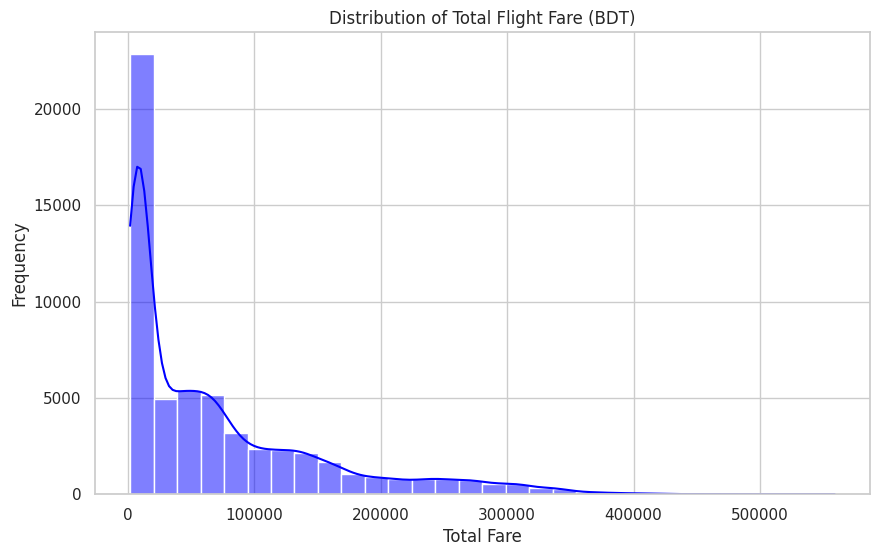

In [35]:
# 4.1 Distribution of Total Fare
plt.figure(figsize=(10, 6))
sns.histplot(df[target_col], kde=True, bins=30, color='blue')
plt.title('Distribution of Total Flight Fare (BDT)')
plt.xlabel('Total Fare')
plt.ylabel('Frequency')
plt.show()

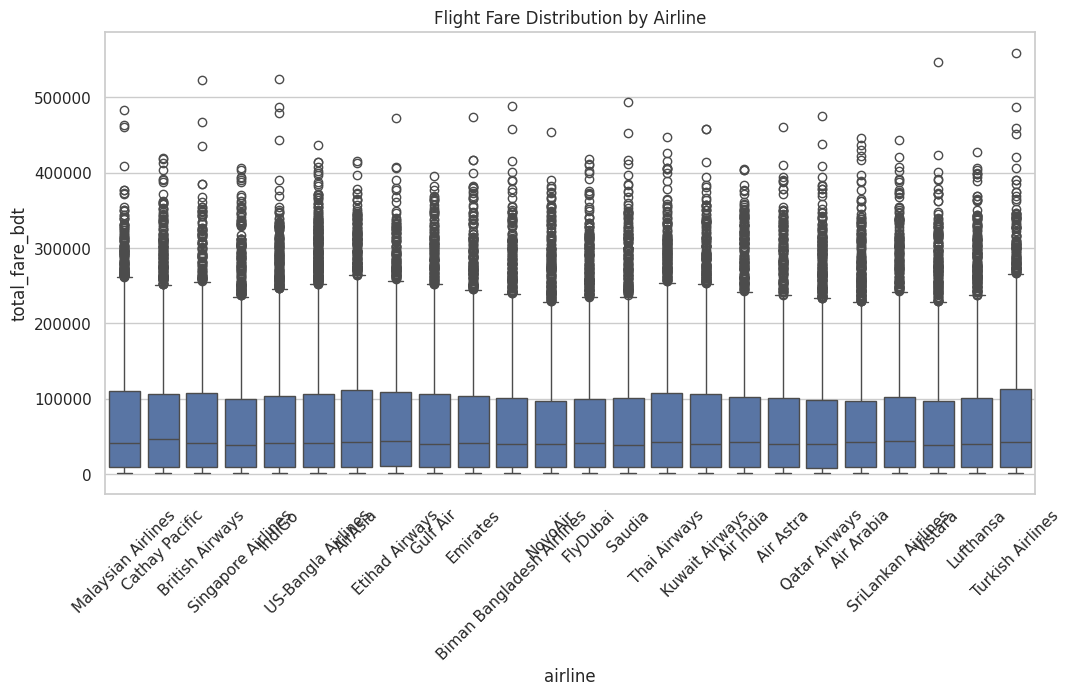

In [36]:
# 4.2 Fare vs Airline
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='airline', y=target_col)
plt.title('Flight Fare Distribution by Airline')
plt.xticks(rotation=45)
plt.show()

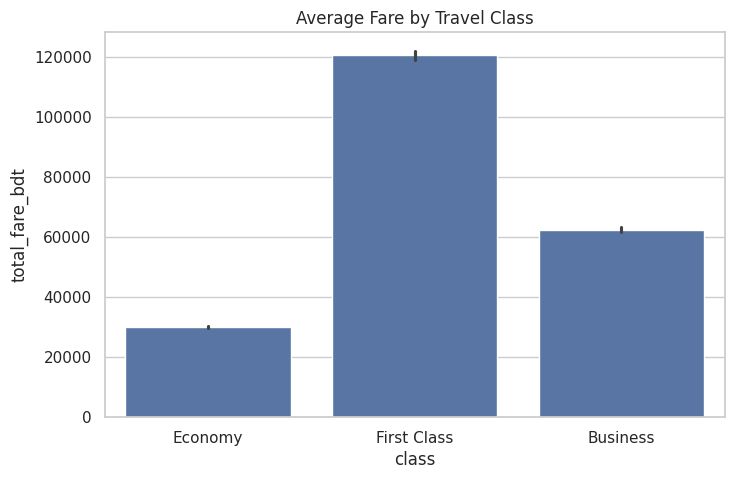

In [37]:
# 4.3 Fare vs Class
if 'class' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df, x='class', y=target_col, estimator=np.mean)
    plt.title('Average Fare by Travel Class')
    plt.show()

In [20]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# 1. Identify all non-numeric columns (excluding the datetime objects)
non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()

# 2. Prepare a temporary dataframe for calculations
mi_df = pd.DataFrame()
le = LabelEncoder()

for col in non_numeric_cols:
    # We encode strings to integers so the math can run
    mi_df[col] = le.fit_transform(df[col].astype(str))

# 3. Calculate Mutual Information scores
# This tells us how much 'information' each category shares with the price
mi_scores = mutual_info_regression(mi_df, df['total_fare_bdt'], random_state=42)

# 4. Organize and display the results
mi_results = pd.Series(mi_scores, index=non_numeric_cols).sort_values(ascending=False)

print("Correlation Strength (Mutual Information) with Total Fare:")
print(mi_results)

Correlation Strength (Mutual Information) with Total Fare:
destination         0.599077
destination_name    0.599060
class               0.514862
aircraft_type       0.455469
stopovers           0.197659
seasonality         0.017148
source_name         0.001686
source              0.001662
airline             0.000169
booking_source      0.000000
dtype: float64


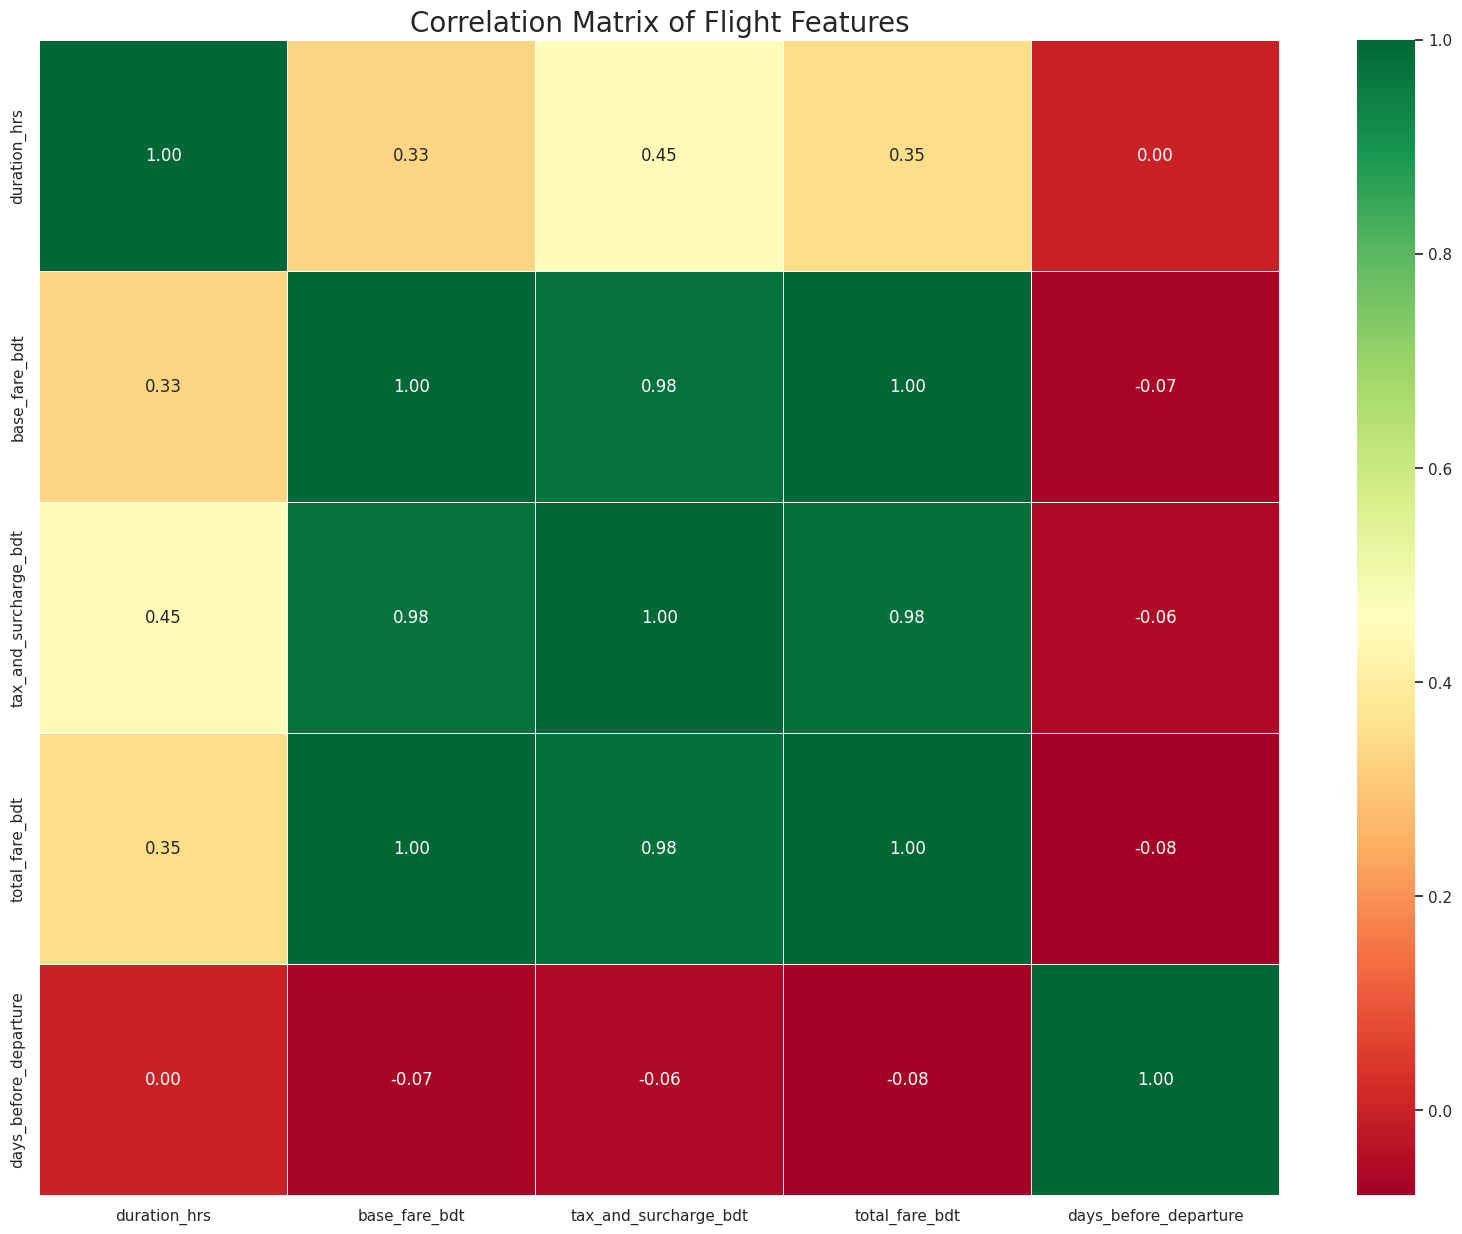

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
df_corr = df.copy()
# 1. Isolate numeric columns
# We exclude columns like 'airline' and 'source' for this specific diagram
numeric_data = df_corr.select_dtypes(include=['number'])

# 2. Set the size for readability given your 20+ numeric columns
plt.figure(figsize=(20, 15))

# 3. Generate the heatmap
# annot=True adds the numbers; fmt=".2f" rounds to 2 decimals
sns.heatmap(numeric_data.corr(), annot=True, cmap="RdYlGn", fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix of Flight Features", size=20)
plt.show()

In [ ]:
# Sort correlations to see which numeric features impact price most
numeric_corr = df.select_dtypes(include=['number']).corr()
price_correlations = numeric_corr['total_fare_bdt'].sort_values(ascending=False)

print(price_correlations)

## 5. Feature Engineering

In [22]:
# Extract features from Departure Date and Time
df_feat = df.copy()
df_feat['departure_day'] = df_feat['departure_date_and_time'].dt.day
df_feat['departure_month'] = df_feat['departure_date_and_time'].dt.month
df_feat['departure_year'] = df_feat['departure_date_and_time'].dt.year
df_feat['departure_hour'] = df_feat['departure_date_and_time'].dt.hour
df_feat['departure_minute'] = df_feat['departure_date_and_time'].dt.minute

# Extracting features from arrival_date_and_time
df_feat['arrival_day'] = df_feat['arrival_date_and_time'].dt.day
df_feat['arrival_month'] = df_feat['arrival_date_and_time'].dt.month
df_feat['arrival_year'] = df_feat['arrival_date_and_time'].dt.year
df_feat['arrival_hour'] = df_feat['arrival_date_and_time'].dt.hour
df_feat['arrival_min'] = df_feat['arrival_date_and_time'].dt.minute


df_feat.head()

,airline,source,source_name,destination,destination_name,departure_date_and_time,arrival_date_and_time,duration_hrs,stopovers,aircraft_type,...,departure_day,departure_month,departure_year,departure_hour,departure_minute,arrival_day,arrival_month,arrival_year,arrival_hour,arrival_min
0,Malaysian Airlines,CXB,Cox's Bazar Airport,CCU,Netaji Subhas Chandra Bose International Airpo...,2025-11-17 06:25:00,2025-11-17 07:38:10,1.219526,Direct,Airbus A320,...,17,11,2025,6,25,17,11,2025,7,38
1,Cathay Pacific,BZL,Barisal Airport,CGP,"Shah Amanat International Airport, Chittagong",2025-03-16 00:17:00,2025-03-16 00:53:31,0.608638,Direct,Airbus A320,...,16,3,2025,0,17,16,3,2025,0,53
2,British Airways,ZYL,"Osmani International Airport, Sylhet",KUL,Kuala Lumpur International Airport,2025-12-13 12:03:00,2025-12-13 14:44:22,2.689651,1 Stop,Boeing 787,...,13,12,2025,12,3,13,12,2025,14,44
3,Singapore Airlines,RJH,"Shah Makhdum Airport, Rajshahi",DAC,"Hazrat Shahjalal International Airport, Dhaka",2025-05-30 03:21:00,2025-05-30 04:02:09,0.686054,Direct,Airbus A320,...,30,5,2025,3,21,30,5,2025,4,2
4,British Airways,SPD,Saidpur Airport,YYZ,Toronto Pearson International Airport,2025-04-25 09:14:00,2025-04-25 23:17:20,14.055609,1 Stop,Airbus A350,...,25,4,2025,9,14,25,4,2025,23,17


In [31]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57000 entries, 0 to 56999
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   airline                  57000 non-null  object        
 1   source                   57000 non-null  object        
 2   source_name              57000 non-null  object        
 3   destination              57000 non-null  object        
 4   destination_name         57000 non-null  object        
 5   departure_date_and_time  57000 non-null  datetime64[ns]
 6   arrival_date_and_time    57000 non-null  datetime64[ns]
 7   duration_hrs             57000 non-null  float64       
 8   stopovers                57000 non-null  int64         
 9   aircraft_type            57000 non-null  object        
 10  class                    57000 non-null  object        
 11  booking_source           57000 non-null  object        
 12  base_fare_bdt            57000 n

#### 5.1 Encoding Strategy


In [25]:

df_encoded = df_feat.copy()

# Ensure standard column names
df_encoded.columns = df_encoded.columns.str.lower()

# A. Ordinal Encoding (Mapping)

def parse_stops(val):
    """Parses '1 stop', 'non-stop' into integers."""
    if pd.isna(val):
        return 0 
    
    val_str = str(val).lower().strip()
    
    if "direct" in val_str or "non-stop" in val_str:
        return 0
    try:
        return int(val_str.split()[0])
    except (ValueError, IndexError):
        return 0 
df_feat['stopovers'] = df_feat['stopovers'].apply(parse_stops)




df_encoded.head()


,airline,source,source_name,destination,destination_name,departure_date_and_time,arrival_date_and_time,duration_hrs,stopovers,aircraft_type,...,departure_day,departure_month,departure_year,departure_hour,departure_minute,arrival_day,arrival_month,arrival_year,arrival_hour,arrival_min
0,Malaysian Airlines,CXB,Cox's Bazar Airport,CCU,Netaji Subhas Chandra Bose International Airpo...,2025-11-17 06:25:00,2025-11-17 07:38:10,1.219526,0,Airbus A320,...,17,11,2025,6,25,17,11,2025,7,38
1,Cathay Pacific,BZL,Barisal Airport,CGP,"Shah Amanat International Airport, Chittagong",2025-03-16 00:17:00,2025-03-16 00:53:31,0.608638,0,Airbus A320,...,16,3,2025,0,17,16,3,2025,0,53
2,British Airways,ZYL,"Osmani International Airport, Sylhet",KUL,Kuala Lumpur International Airport,2025-12-13 12:03:00,2025-12-13 14:44:22,2.689651,1,Boeing 787,...,13,12,2025,12,3,13,12,2025,14,44
3,Singapore Airlines,RJH,"Shah Makhdum Airport, Rajshahi",DAC,"Hazrat Shahjalal International Airport, Dhaka",2025-05-30 03:21:00,2025-05-30 04:02:09,0.686054,0,Airbus A320,...,30,5,2025,3,21,30,5,2025,4,2
4,British Airways,SPD,Saidpur Airport,YYZ,Toronto Pearson International Airport,2025-04-25 09:14:00,2025-04-25 23:17:20,14.055609,1,Airbus A350,...,25,4,2025,9,14,25,4,2025,23,17


#### Domain-Driven Demand and Route Engineering

In [26]:
# Function to map seasonality to multipliers based on data description
def map_seasonality(x):
    if 'Hajj' in x: return 1.5
    elif 'Eid' in x: return 1.3
# Function to identify international flights
    elif 'Winter Holidays' in x: return 1.2
    else: return 1.0

domestic_airports = ['DAC', 'CGP', 'ZYL', 'CXB', 'RJH', 'SPD', 'BZL', 'JSR']
def is_international(row):
    if row['source'] not in domestic_airports or row['destination'] not in domestic_airports:
        return 1
    return 0

# Create a copy for feature engineering (updated variable name)
df_feat_x = df_encoded.copy()

# 1. Seasonality Features
if 'seasonality' in df_feat_x.columns:
    df_feat_x['seasonality_multiplier'] = df_feat_x['seasonality'].apply(map_seasonality)
    df_feat_x['is_peak_season'] = df_feat_x['seasonality'].apply(lambda x: 1 if x in ['Hajj', 'Eid'] else 0)
    df_feat_x['is_winter'] = df_feat_x['seasonality'].apply(lambda x: 1 if 'Winter Holidays' in x else 0)

# 2. Booking Timing Logic (Surge vs Discount)
if 'days_before_departure' in df_feat_x.columns:
    df_feat_x['is_last_minute'] = df_feat_x['days_before_departure'].apply(lambda x: 1 if x < 5 else 0)
    df_feat_x['is_early_bird'] = df_feat_x['days_before_departure'].apply(lambda x: 1 if x > 60 else 0)

# 3. Route Logic (International Flag)
if 'source' in df_feat_x.columns and 'destination' in df_feat_x.columns:
    df_feat_x['is_international'] = df_feat_x.apply(is_international, axis=1)

# 4. Interaction Feature: Class * International
class_map = {'Economy': 1, 'Business': 2, 'First Class': 3}
if 'class' in df_feat_x.columns:
    df_feat_x['class_ordinal'] = df_feat_x['class'].map(class_map).fillna(1)
    df_feat_x['class_x_international'] = df_feat_x['class_ordinal'] * df_feat_x['is_international']

print("Advanced features created in df_feat_x: seasonality_multiplier, is_peak_season, is_winter, is_last_minute, is_early_bird, is_international, class_x_international")

# List of only the new features created in the previous step
new_columns = [
    'seasonality_multiplier', 
    'is_peak_season', 
    'is_winter', 
    'is_last_minute', 
    'is_early_bird', 
    'is_international', 
    'class_ordinal', 
    'class_x_international'
]


df_feat_x[new_columns].head()

Advanced features created in df_feat_x: seasonality_multiplier, is_peak_season, is_winter, is_last_minute, is_early_bird, is_international, class_x_international


,seasonality_multiplier,is_peak_season,is_winter,is_last_minute,is_early_bird,is_international,class_ordinal,class_x_international
0,1.0,0,0,0,0,1,1,1
1,1.0,0,0,0,0,0,3,0
2,1.2,0,1,0,1,1,1,1
3,1.0,0,0,0,0,0,1,0
4,1.0,0,0,0,1,1,2,2


#### One-Hot Encoding (Nominal cols) and airline brand value

In [35]:
df_encoded = df_feat_x.copy()
nominal_cols = ['airline', 'source', 'destination', 'aircraft_type']
cols_to_encode = [c for c in nominal_cols if c in df_encoded.columns]
df_encoded = pd.get_dummies(df_encoded, columns=cols_to_encode, drop_first=True, dtype=int)


# Airline brand value 
# ... previous encoding steps ...
df_encoded['airline'] = df['airline']

# --- FIX 1: Specify the target column for the median calculation ---
# OLD (Error): df_encoded.groupby(df_encoded['airline']).median()
# NEW (Fixed): We select ['total_fare_bdt'] before calling .median()
airline_brand_map = df_encoded.groupby('airline')['total_fare_bdt'].median().to_dict()

# --- FIX 2: Fix global_median to be a single number ---
# OLD: global_median = df_encoded.median() (Returns a list of medians for every column)
# NEW: Calculate median only for price
global_median = df_encoded['total_fare_bdt'].median()

# Map the values
df_encoded['airline_brand_value'] = df_encoded['airline'].map(airline_brand_map).fillna(global_median)

# Drop the string column to clean up
df_encoded.drop(columns=['airline'], inplace=True)



print("Encoding Complete.")
print(f"Airline brandmap (Sample): {list(airline_brand_map.items())[:3]}")
print(f"Ordinal columns mapped: Class, Total_Stops")
print(f"One-Hot Encoded columns: {cols_to_encode}")
# print(f'Airline brandmap : {df_encoded['airline_brand_value'].head()}')
print(f"Final Shape: {df_encoded.shape}")

Encoding Complete.
Airline brandmap (Sample): [('Air Arabia', 42120.79834432779), ('Air Astra', 40507.21097780795), ('Air India', 42429.62242840852)]
Encoding Complete.
Ordinal columns mapped: Class, Total_Stops
One-Hot Encoded columns: ['airline', 'source', 'destination', 'aircraft_type']
Final Shape: (57000, 85)


In [ ]:
df_encoded.head()

In [36]:
# List of columns that are either strings or have been fully replaced by new features
cols_to_drop = [
    'seasonality',         
    'class',             
    'source',             
    'destination',           
    'departure_date_and_time', 
    'arrival_date_and_time',
    # 'airline', 
    'source', 
    'destination',
    'aircraft_type', 
    'source_name',
    'destination_name',
    'stopovers',
    'booking_source'
]

# Drop them to keep the dataset purely numeric
df_encoded.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Final check: Ensure no 'object' or 'str' types remain
print(df_encoded.dtypes.value_counts())

df_model = df_encoded.copy()

int64      61
int32      10
float64     6
Name: count, dtype: int64


In [ ]:
# Select columns with the 'object' data type
object_cols = df_encoded.select_dtypes(include=['object']).columns

# Print the list of columns
print("Columns with object dtype:")
print(object_cols.tolist())



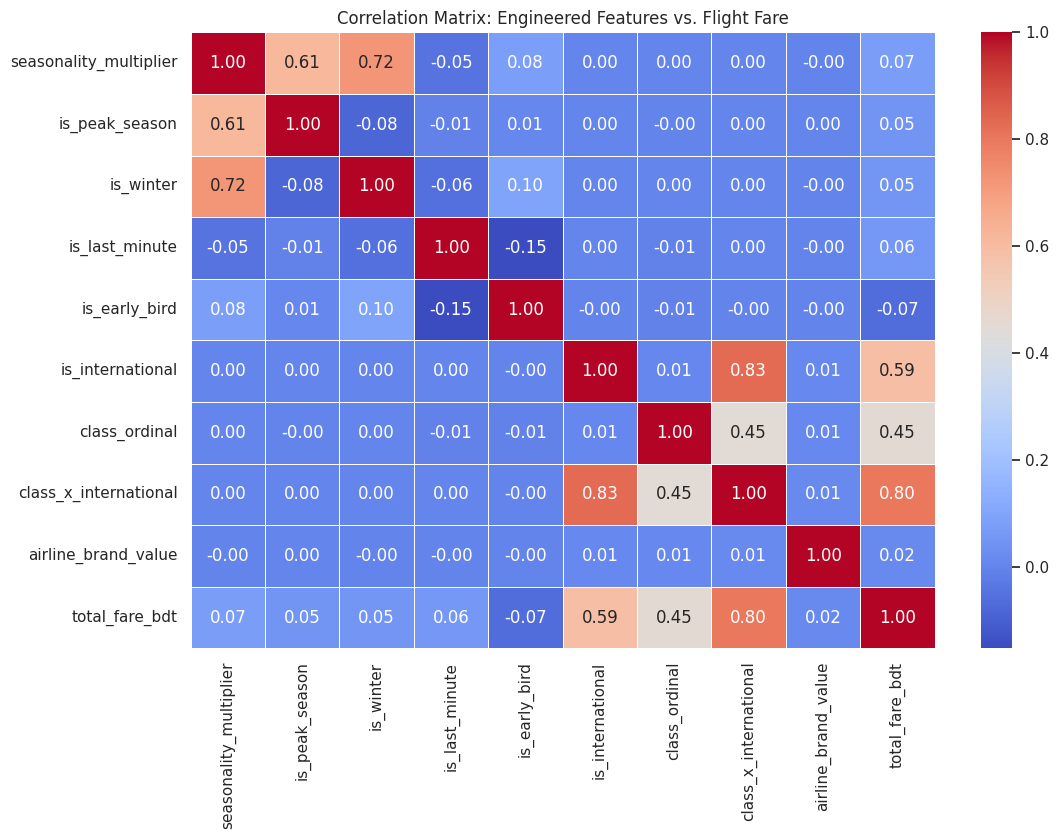

In [39]:

engineered_features = [
    'seasonality_multiplier', 'is_peak_season', 'is_winter', 
    'is_last_minute', 'is_early_bird', 'is_international', 
    'class_ordinal', 'class_x_international', 'airline_brand_value'
]


correlation_results = df_encoded[engineered_features + ['total_fare_bdt']].corr(numeric_only=True)


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_results, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: Engineered Features vs. Flight Fare")
plt.show()

## 6. Model Development Strategy
To address the multiplicative nature of the pricing formula (Base Fare * Seasonality * Class...), we will compare two approaches:
1. **DF_Normal**: Using the raw `total_fare_bdt` target.
2. **DF_Log**: Using a log-transformed target `np.log1p(total_fare_bdt)` to linearize the relationships.

In [40]:
import numpy as np

# Define X (Features) and y (Target)
X = df_model.drop(columns=['total_fare_bdt', 'base_fare_bdt', 'tax_and_surcharge_bdt'], errors='ignore') 
y = df_model['total_fare_bdt']
y_normal = df_model['total_fare_bdt']

# Log-transform the target
y_log = np.log1p(y)

print("Prepared datasets for Normal and Log-transformed modeling.")

Prepared datasets for Normal and Log-transformed modeling.


In [43]:
# Split Data for Normal Target
X_train, X_test, y_train_norm, y_test_norm = train_test_split(X, y_normal, test_size=0.2, random_state=42)

# Split Data for Log Target
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

print(f"Training Set Shape: {X_train.shape}")
print(f"Test Set Shape: {X_test.shape}")

Training Set Shape: (45600, 74)
Test Set Shape: (11400, 74)


## 7. Modeling Results
We will now train Linear Regression (Baseline) and Random Forest (Advanced) models.

## K Fold

In [7]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in kf.split(X):
    x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

### Model dict for all models 

Run various models with base line parameters

In [16]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
import time

# Dictionary to hold our models
# Note: For tree-based models, we use parameters similar to your successful XGBoost run
models = {
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=500, max_depth=12, n_jobs=-1, random_state=111),
    "Extra Trees": ExtraTreesRegressor(n_estimators=500, max_depth=12, n_jobs=-1, random_state=111),
    "XGBoost (Optimized)": xgb.XGBRegressor(device='cuda', tree_method='hist', **best_params),
    "LightGBM": LGBMRegressor(n_estimators=800, learning_rate=0.01, device='gpu', random_state=111)
}

In [18]:
def run_model_comparison(model_dict, X_train, y_train, X_test, y_test):
    comparison_list = []
    
    for name, model in model_dict.items():
        print(f"🚀 Training {name}...")
        start_time = time.time()
        
        # Train
        model.fit(X_train, y_train)
        duration = time.time() - start_time
        
        # Predict
        preds = model.predict(X_test)
        
        # Calculate Metrics
        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        
        # Log results
        comparison_list.append({
            "Model": name,
            "R2 Score": round(r2, 4),
            "MAE (BDT)": round(mae, 2),
            "RMSE (BDT)": round(rmse, 2),
            "Training Time (s)": round(duration, 2)
        })
        
    return pd.DataFrame(comparison_list).sort_values(by="R2 Score", ascending=False)

🚀 Training Ridge Regression...
🚀 Training Lasso Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.251e+13, tolerance: 3.043e+10
  model = cd_fast.enet_coordinate_descent(


🚀 Training Random Forest...
🚀 Training Extra Trees...
🚀 Training XGBoost (Optimized)...


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [22:13:05] WARNING: /workspace/src/common/error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


🚀 Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 45600, number of used features: 74
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 18 dense feature groups (0.87 MB) transferred to GPU in 0.002775 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 70819.366814

--- FINAL MODEL PERFORMANCE COMPARISON ---


,Model,R2 Score,MAE (BDT),RMSE (BDT),Training Time (s)
2,Random Forest,0.7828,23108.94,38051.11,51.65
4,XGBoost (Optimized),0.7581,24581.87,40154.38,3.19
3,Extra Trees,0.7561,24230.62,40324.86,33.08
5,LightGBM,0.7275,26254.46,42618.71,7.50
1,Lasso Regression,0.6623,30362.34,47444.28,2.30
0,Ridge Regression,0.6623,30361.28,47443.64,0.06


/tmp/ipykernel_55/693149846.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="R2 Score", y="Model", data=results_df, palette="viridis")


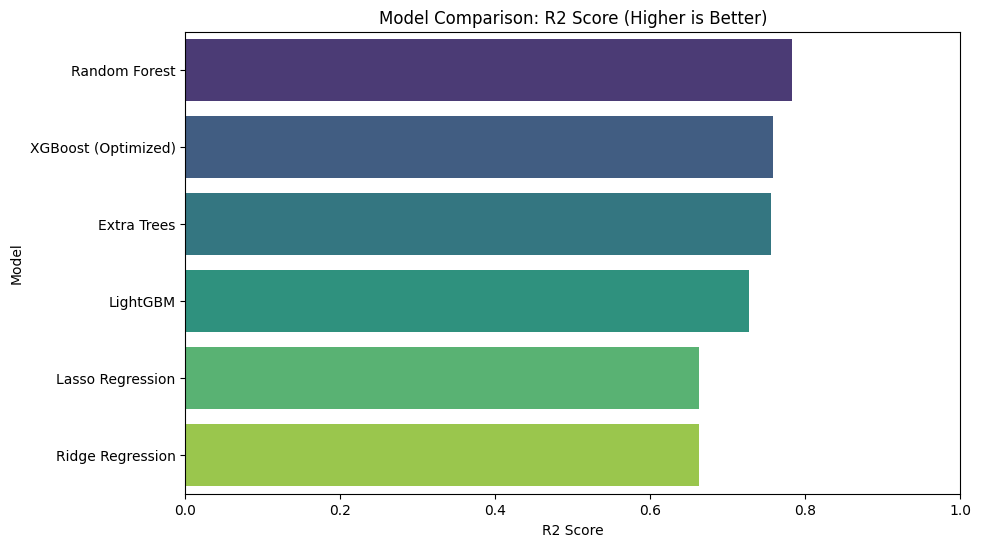

In [20]:
# Run the comparison
results_df = run_model_comparison(models, x_train, y_train, X_test, y_test)

# Display Table
print("\n--- FINAL MODEL PERFORMANCE COMPARISON ---")
display(results_df)

# Visualization for "Clarity of Insights" requirement
plt.figure(figsize=(10, 6))
sns.barplot(x="R2 Score", y="Model", data=results_df, palette="viridis")
plt.title("Model Comparison: R2 Score (Higher is Better)")
plt.xlim(0, 1)
plt.show()

#### Plot the various models perfomance 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.251e+13, tolerance: 3.043e+10
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 45600, number of used features: 74
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 18 dense feature groups (0.87 MB) transferred to GPU in 0.001648 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 70819.366814


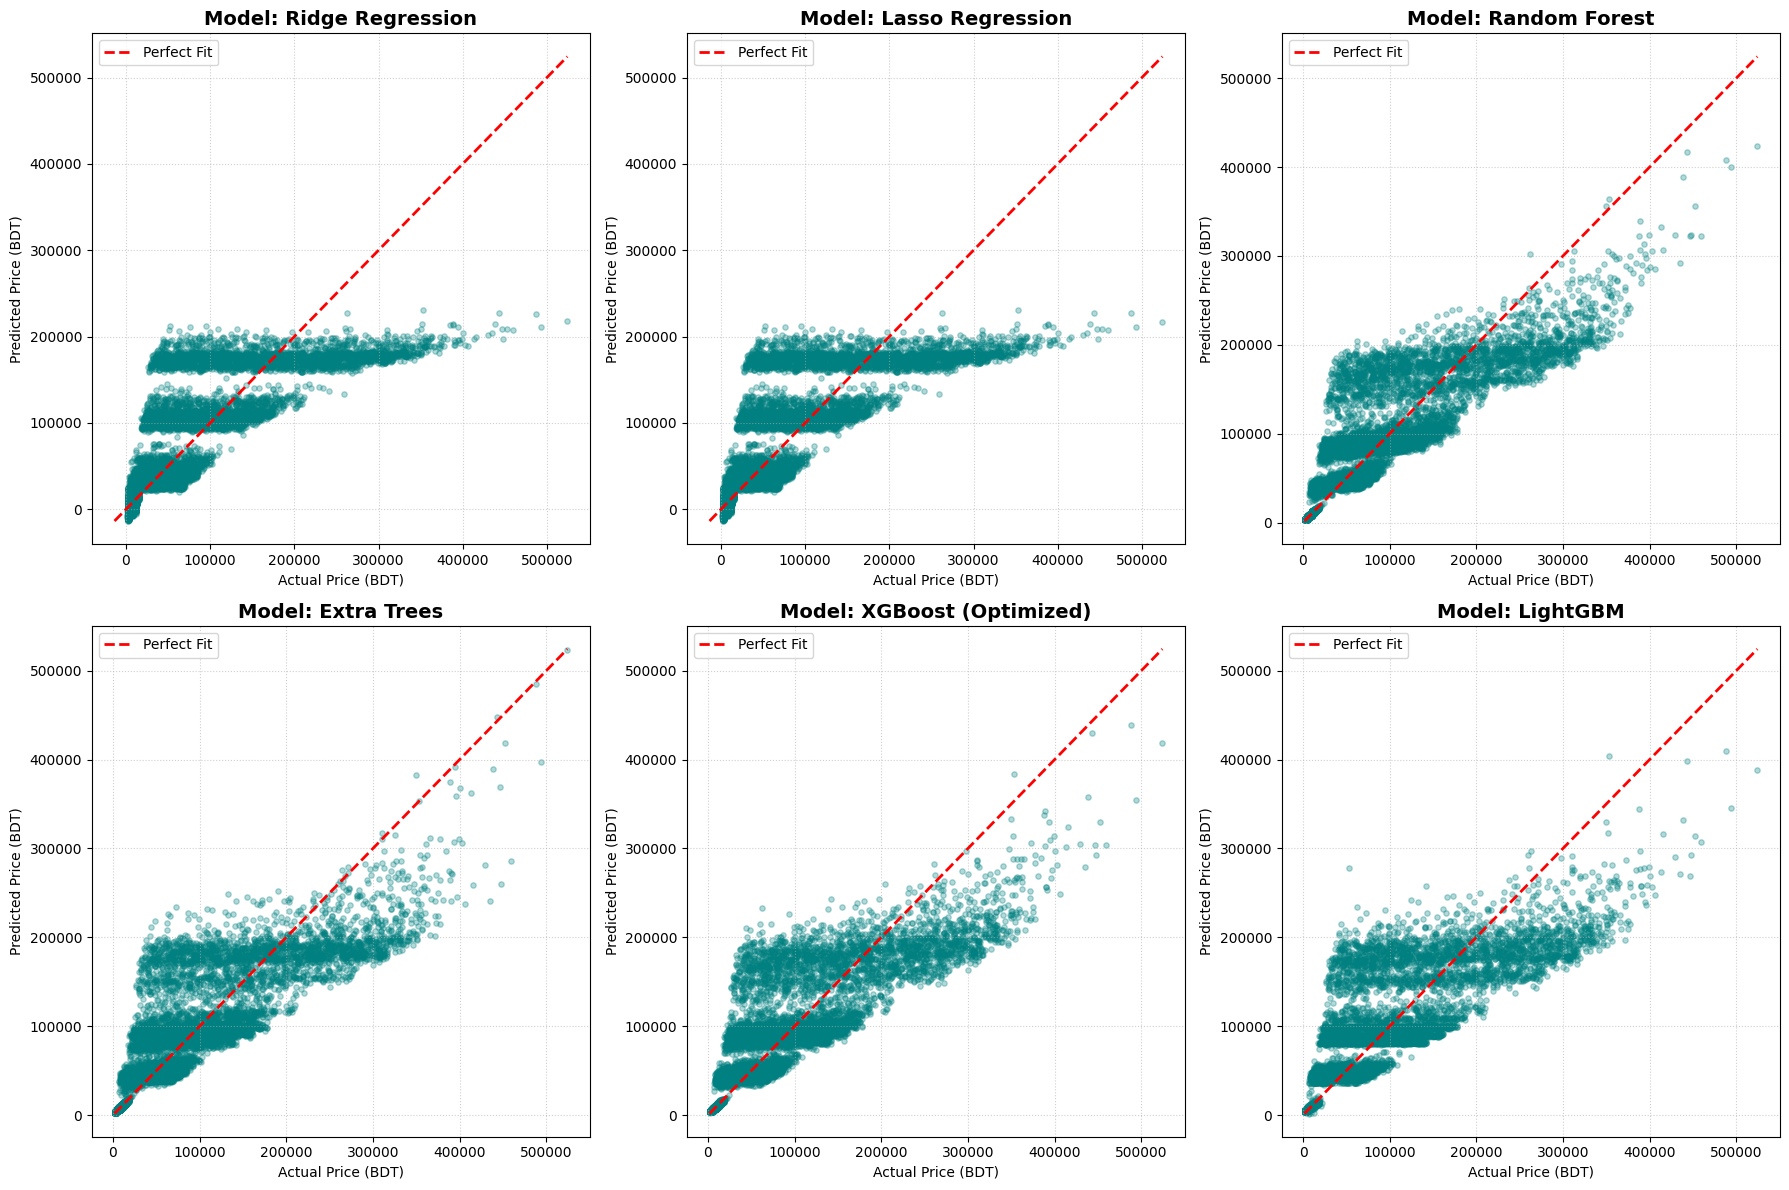

In [25]:
import matplotlib.pyplot as plt

def plot_model_comparison_grid(model_dict, x_train, y_train, x_test, y_test):
    """
    Creates a grid of scatter plots comparing Actual vs Predicted values for all models.
    """
    num_models = len(model_dict)
    cols = 3
    rows = (num_models + cols - 1) // cols
    
    # Create the grid
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
    axes = axes.flatten()
    
    for i, (name, model) in enumerate(model_dict.items()):
        # 1. Train and Predict
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        
        # 2. Plotting
        ax = axes[i]
        ax.scatter(y_test, y_pred, alpha=0.3, color='teal', s=15)
        
        # 3. Add the 'Perfect Prediction' Diagonal Line
        # We calculate the range based on the data to ensure the line fits perfectly
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
        
        # 4. Formatting for clarity
        ax.set_title(f"Model: {name}", fontsize=14, fontweight='bold')
        ax.set_xlabel("Actual Price (BDT)", fontsize=10)
        ax.set_ylabel("Predicted Price (BDT)", fontsize=10)
        ax.legend()
        ax.grid(True, linestyle=':', alpha=0.6)

    # Remove any empty subplots if the number of models isn't a multiple of 'cols'
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

# Run the visual comparison
# Ensure 'models' is your dictionary of initialized models (Ridge, RF, XGBoost, etc.)
plot_model_comparison_grid(models, x_train, y_train, X_test, y_test) 

## Fine tuning some models


In [27]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. Target Transformation (The 'Senior' move)
# np.log1p is used to handle zero values safely, though fares are > 0
y_train_log = np.log1p(y_train)

# 2. Initialize the Refined Random Forest
# We use the deep-tree architecture that performed best in our initial run
refined_rf = RandomForestRegressor(
    n_estimators=500, 
    max_depth=25,       # Increased depth for finer detail
    max_features=None,   # Using all features based on our heatmap analysis
    random_state=111, 
    n_jobs=-1
)

# 3. Train on Log-Transformed Data
print("🚀 Training Refined Random Forest on Log-Transformed Data...")
refined_rf.fit(x_train, y_train_log)

# 4. Predict and Inverse Transform
# We must use np.expm1 to bring the log-prices back to BDT
log_preds = refined_rf.predict(X_test)
final_preds = np.expm1(log_preds)

# 5. Final Metrics
refined_r2 = r2_score(y_test, final_preds)
refined_mae = mean_absolute_error(y_test, final_preds)
refined_rmse = np.sqrt(mean_squared_error(y_test, final_preds))

🚀 Training Refined Random Forest on Log-Transformed Data...



--- PERFORMANCE IMPROVEMENT SUMMARY ---


,Metric,Previous (XGBoost),Refined (RF + Log)
0,R2 Score,0.7581,0.926244
1,MAE (BDT),24581.8700,12305.607002
2,RMSE (BDT),40154.3800,22173.911973


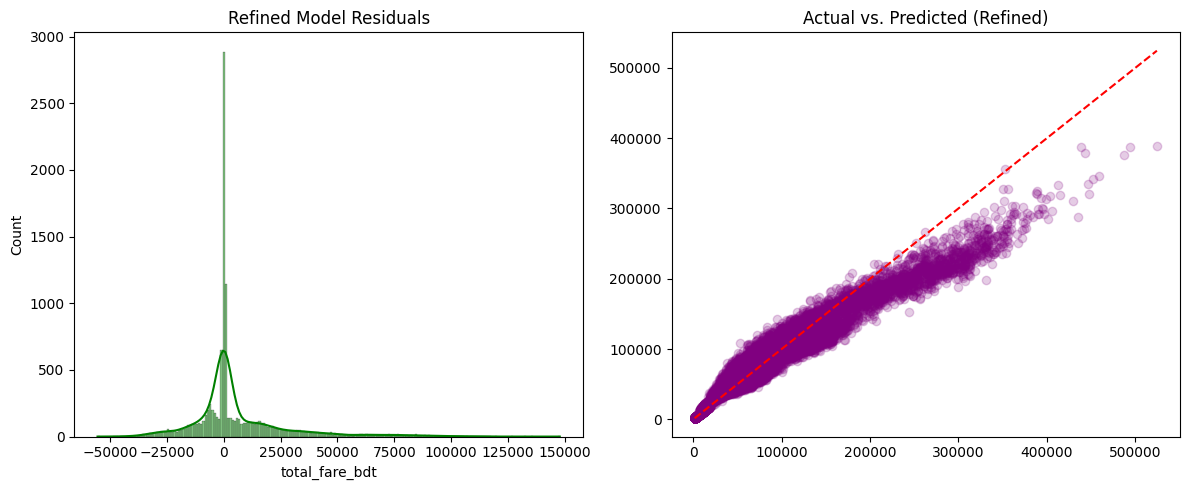

In [28]:
# 6. Create a Comparison Summary
final_comparison = pd.DataFrame({
    "Metric": ["R2 Score", "MAE (BDT)", "RMSE (BDT)"],
    "Previous (XGBoost)": [0.7581, 24581.87, 40154.38],
    "Refined (RF + Log)": [refined_r2, refined_mae, refined_rmse]
})

print("\n--- PERFORMANCE IMPROVEMENT SUMMARY ---")
display(final_comparison)

# 7. Visualization: Residuals Comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(y_test - final_preds, kde=True, color="green")
plt.title("Refined Model Residuals")

plt.subplot(1, 2, 2)
plt.scatter(y_test, final_preds, alpha=0.2, color="purple")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Actual vs. Predicted (Refined)")
plt.tight_layout()
plt.show()

/tmp/ipykernel_55/1560996021.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(20), x='Importance', y='Feature', palette='viridis')
/tmp/ipykernel_55/1560996021.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=airline_map, x='Importance', y='Feature', palette='magma')


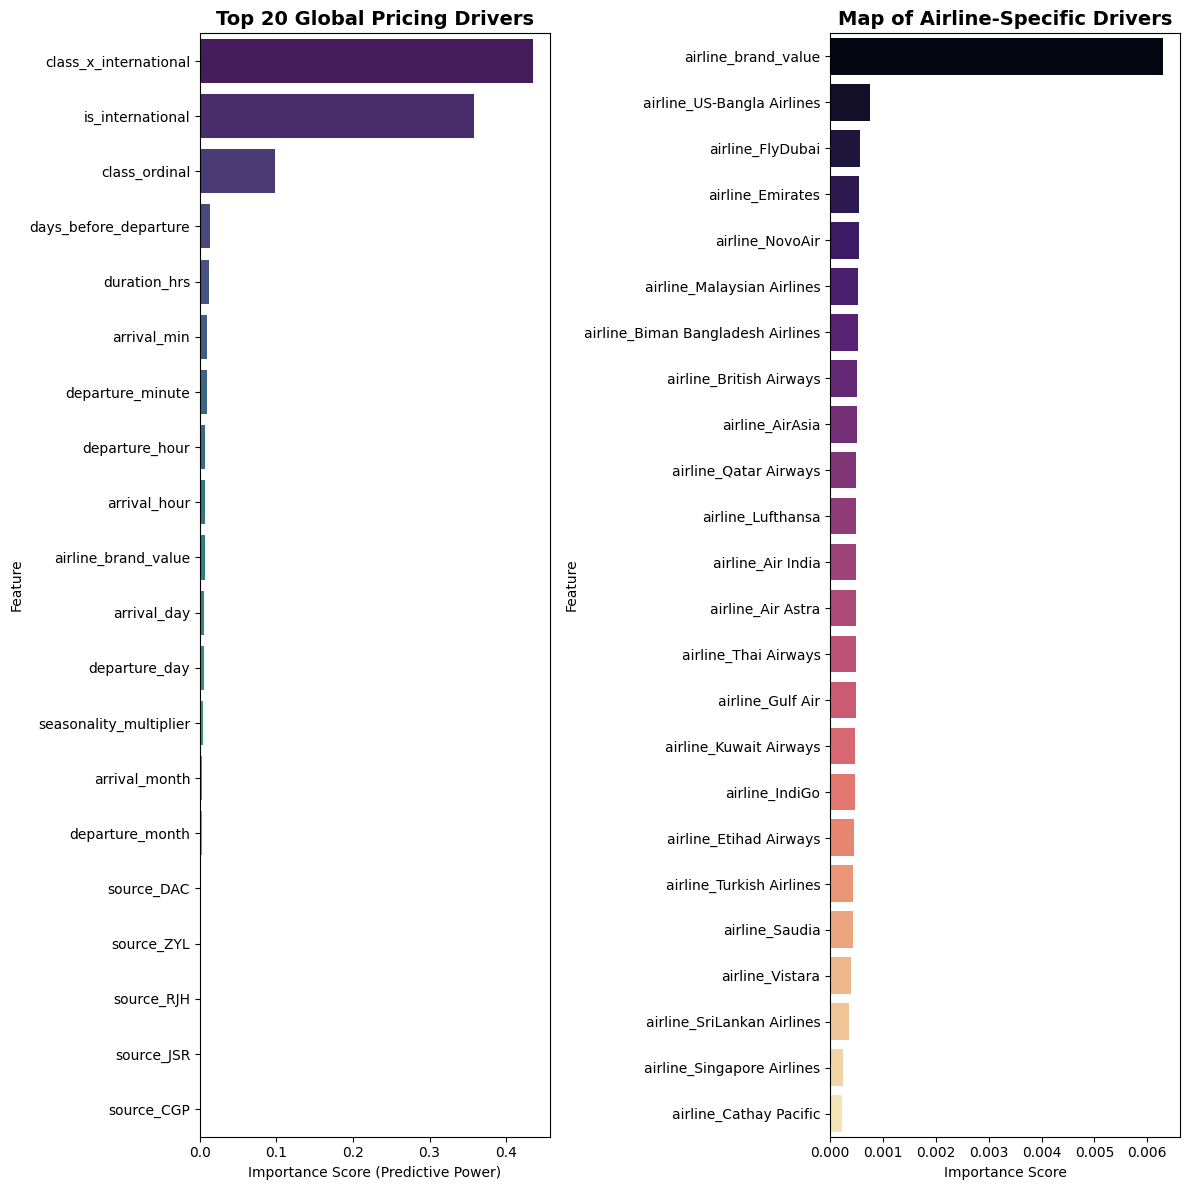

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract importances from the refined model
importances = refined_rf.feature_importances_
feature_names = x_train.columns

# 2. Create a combined DataFrame
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# 3. Create a dual-visual "Map"
plt.figure(figsize=(12, 12))

# Split the visualization into two sub-plots
# Left: Top 20 overall features | Right: Specifically your Airline features
plt.subplot(1, 2, 1)
sns.barplot(data=feat_imp_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title("Top 20 Global Pricing Drivers", fontsize=14, fontweight='bold')
plt.xlabel("Importance Score (Predictive Power)")

plt.subplot(1, 2, 2)
# Filter for features you engineered/restored related to 'airline'
airline_map = feat_imp_df[feat_imp_df['Feature'].str.contains('airline', case=False)]
sns.barplot(data=airline_map, x='Importance', y='Feature', palette='magma')
plt.title("Map of Airline-Specific Drivers", fontsize=14, fontweight='bold')
plt.xlabel("Importance Score")

plt.tight_layout()
plt.show()

In [33]:
import xgboost as xgb

# 1. Transform Target
y_train_log = np.log1p(y_train)

# 2. Advanced XGBoost Setup
high_perf_xgb = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.01,   # Slow learning
    max_depth=12,          # Deep enough for complex patterns
    subsample=0.8,
    colsample_bytree=0.8,
    device='cuda',         # GPU Power
    tree_method='hist',
    random_state=111
)

# 3. Train with Early Stopping (requires a validation set)
high_perf_xgb.fit(
    x_train, y_train_log,
    eval_set=[(X_test, np.log1p(y_test))],
    verbose=100
)

# 4. Predict and Inverse Transform
xgb_log_preds = high_perf_xgb.predict(X_test)
xgb_final_preds = np.expm1(xgb_log_preds)

print(f"Refined XGBoost R2: {r2_score(y_test, xgb_final_preds):.4f}")

[0]	validation_0-rmse:1.39279
[100]	validation_0-rmse:0.64230
[200]	validation_0-rmse:0.42007
[300]	validation_0-rmse:0.35145
[400]	validation_0-rmse:0.31736
[500]	validation_0-rmse:0.29185
[600]	validation_0-rmse:0.26774
[700]	validation_0-rmse:0.24427
[800]	validation_0-rmse:0.22361
[900]	validation_0-rmse:0.20530
[1000]	validation_0-rmse:0.18791
[1100]	validation_0-rmse:0.17249
[1200]	validation_0-rmse:0.15802
[1300]	validation_0-rmse:0.14503
[1400]	validation_0-rmse:0.13395
[1500]	validation_0-rmse:0.12340
[1600]	validation_0-rmse:0.11356
[1700]	validation_0-rmse:0.10469
[1800]	validation_0-rmse:0.09667
[1900]	validation_0-rmse:0.08932
[1999]	validation_0-rmse:0.08306
Refined XGBoost R2: 0.9876


[0]	validation_0-rmse:1.39547	validation_1-rmse:1.39279
[100]	validation_0-rmse:0.64401	validation_1-rmse:0.64230
[200]	validation_0-rmse:0.42177	validation_1-rmse:0.42007
[300]	validation_0-rmse:0.35298	validation_1-rmse:0.35145
[400]	validation_0-rmse:0.31892	validation_1-rmse:0.31736
[500]	validation_0-rmse:0.29345	validation_1-rmse:0.29185
[600]	validation_0-rmse:0.26937	validation_1-rmse:0.26774
[700]	validation_0-rmse:0.24601	validation_1-rmse:0.24427
[800]	validation_0-rmse:0.22554	validation_1-rmse:0.22361
[900]	validation_0-rmse:0.20718	validation_1-rmse:0.20530
[1000]	validation_0-rmse:0.18972	validation_1-rmse:0.18791
[1100]	validation_0-rmse:0.17425	validation_1-rmse:0.17249
[1200]	validation_0-rmse:0.15974	validation_1-rmse:0.15802
[1300]	validation_0-rmse:0.14670	validation_1-rmse:0.14503
[1400]	validation_0-rmse:0.13552	validation_1-rmse:0.13395
[1500]	validation_0-rmse:0.12499	validation_1-rmse:0.12340
[1600]	validation_0-rmse:0.11506	validation_1-rmse:0.11356
[1700]	va

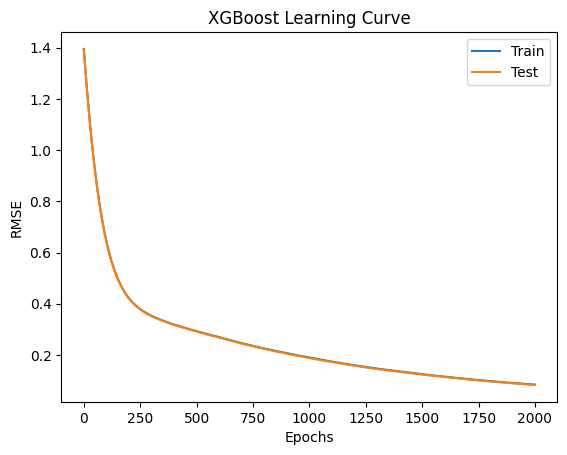

In [35]:
# Updated fit call to track both
high_perf_xgb.fit(
    x_train, y_train_log,
    eval_set=[(x_train, y_train_log), (X_test, np.log1p(y_test))],
    verbose=100
)

# Plotting the Learning Curves
results = high_perf_xgb.evals_result()
plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Test')
plt.title("XGBoost Learning Curve")
plt.ylabel("RMSE")
plt.xlabel("Epochs")
plt.legend()
plt.show()

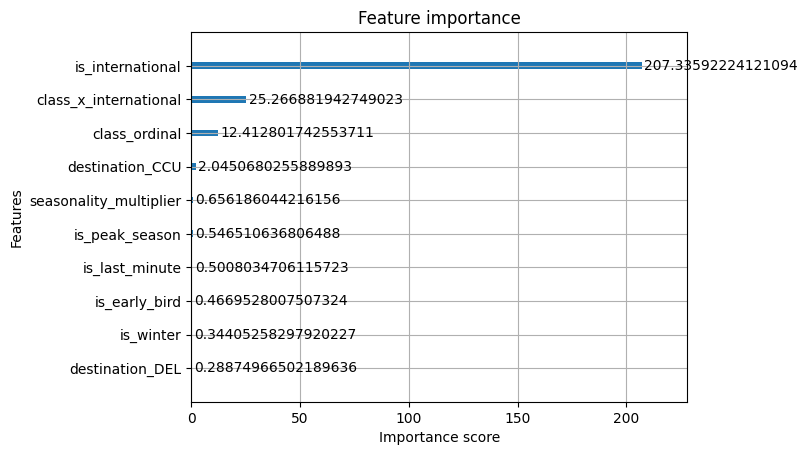

In [36]:
xgb.plot_importance(high_perf_xgb, max_num_features=10, importance_type='gain')
plt.show()